### Datasets and data processing

This notebook summarises the cleaning and processing of the datasets on which this work relies.

In [56]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Reservoir water level data
Daily water level data from Reservoir No. 3 is available from March 2012 to December 2016, measured at a gauge located on the barrage . Annual water level rise was defined as the change in water level between the lowest value and the mean value of the subsequent peak. For modelling, missing data points were filled using linear interpolation.

In [100]:
# Read into df, set datetime index
res3 = pd.read_csv('../02-data/original-data/barrage/barrage-20122016.csv',names=('date','wl'))
res3.date = pd.to_datetime(res3.date,dayfirst=True)
res3 = res3.set_index(res3.date)

# Reindex with full date range
res3 = res3.reindex(pd.date_range('2012-03-01','2016-12-31'))
res3 = res3.drop(columns=('date'))

#Interpolate over NaN values
res3 = res3.interpolate()

#pickle the output
#res3.to_pickle('../02-data/clean-data/barrage-interpolated-20122016.pkl')

Text(0, 0.5, 'head (m)')

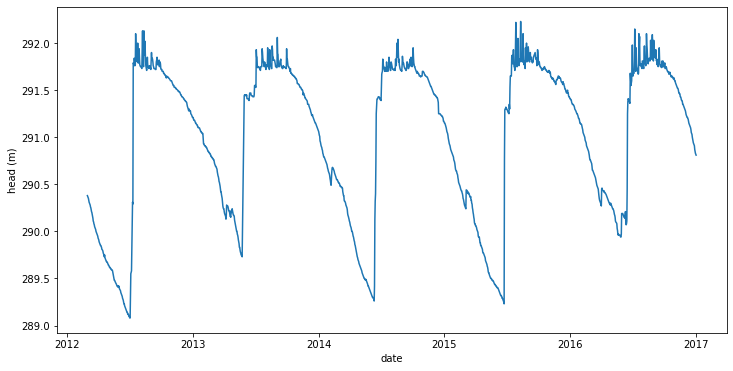

In [103]:
#plot data to check
fig = plt.figure(figsize=(12,6))
plt.plot(res3.index,res3.wl)
plt.xlabel('date')
plt.ylabel('head (m)')

#### Piezometric data
Data are available from the CIEH borehole for the period 1978-2016, with observations taken by dipper from 1978 to 2015 at weekly to monthly intervals, with some gaps, and daily by datalogger since 2015. Annual groundwater rise was defined as the change in hydraulic head between the lowest annual value (usually in May or June), and the subsequent annual peak (usually in October or November). Annual decline was defined as the change in head between the annual maximum and the subsequent year’s minimum. 

NB systematic error for reference point.

In [70]:
#load and pickle data
cieh = pd.read_csv('../02-data/original-data/borehole/CIEH-04781216.csv',names=('date','gwl'))
cieh.date = pd.to_datetime(cieh.date,dayfirst=True)
#cieh.to_pickle('../02-data/clean-data/cieh19782016.pkl')

Text(0, 0.5, 'head (m)')

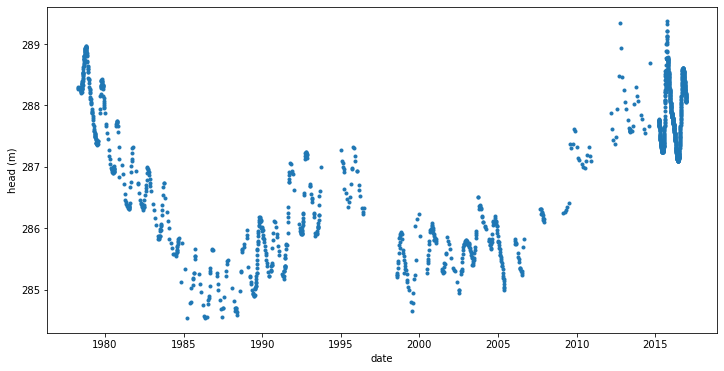

In [73]:
#plot indicative data
fig = plt.figure(figsize=(12,6))
plt.plot(cieh.date,cieh.gwl,'.',label='CIEH')
plt.xlabel('date')
plt.ylabel('head (m)')

#### Climate data
Daily precipitation and reference evapotranspiration data were obtained from the closest weather station at Ouagadougou Airport, approximately 4 km southwest of the study area. Daily data for a number of climatic variables was available for the period 1961-2016, with a few missing days. The original data was in a rather eccentric Excel format which required a certain amount of cleaning and reorganisation in order to be useful. For the few missing days of precipitation data, a value of zero was assumed.

In [107]:
#clean the Ouaga climate data

def clean(filename,var,startyear,endyear):
    '''Cleans the weirdly formatted climate data from Ouaga, return pandas df with just date and variable.
    
    Arguments:
    ==========
    filename (str): CSV file in data folder
    var (str): variable in English we're looking at
    startyear (int): first year of data
    endyear (int): last year of data (inclusive)'''
    
    #load data with column names
    cols = [0,1,2,3,4,5,6,7,8,9,10,11,12]
    names = ('day','01','02','03','04','05','06','07','08','09','10','11','12')
    df = pd.read_csv(f'../02-data/original-data/climate/{filename}.csv',names=names,usecols=cols,
                    encoding="ISO-8859-1")

    #get rid of extra rows and random text
    df = df[(df.day!='DEC')&(df.day!='MOIS')&(df.day!='TOTAL')& \
            (df.day!='DATE')&(df.day!='JRS')&(df.day.notna())]

    #generate years column
    years = []
    for i in range(startyear,endyear+1):
        yr = [i]*31
        years = years + yr
    df['year'] = years

    #melt to normal-looking table
    value_vars = ['01','02','03','04','05','06','07','08','09','10','11','12']
    df = pd.melt(df,id_vars=['year','day'],
              value_vars=value_vars,
              var_name='month',value_name=var)

    #convert days and months to int
    df.day = df.day.astype('int64')
    df.month = df.month.astype('int64')

    #get rid of rows with rainfall NaN (non-existent dates)
    df = df[df.rainfall.notna()]

    #catch stray months with extra days
    m = ['04','06','09','11']
    df = df[~((df.month.isin(m))&(df.day>30))]
    df = df[~((df['month']==2)&(df.day>29))]

    #reindex
    df = df.reset_index(drop=True)

    #convert YMD to datetime
    df['date'] = pd.to_datetime(df[['year','month','day']],dayfirst=True)

    #replace all the weird symbols with NaN and convert variable to float
    df = df.replace(to_replace='**',value=0) #missing days
    df = df.replace(to_replace='.',value=0)
    df = df.replace(to_replace='TR',value=0)
    df['rainfall'] = df['rainfall'].astype('float64')

    final = df[['date','rainfall']]
    
    return final


In [125]:
#load all rainfall data, compare and combine

r6104 = clean('rainfall-19612004','rainfall',1961,2004)
r0409 = clean('rainfall-20042009','rainfall',2004,2009)
r1017 = pd.read_csv('../02-data/original-data/climate/rainfall20102017.csv',names=('date','rainfall'))
r1017['date']= pd.to_datetime(r1017['date'],dayfirst=True)

#concatenate
r_all = pd.concat([r6104,r0409,r1017],ignore_index=True,copy=False)

#set datetime index and sort
r_all = r_all.set_index('date')
r_all = r_all.sort_index()

#pickle
#r_all.to_pickle('../02-data/clean-data/rainfall19612017.pkl')

(0, 274.365)

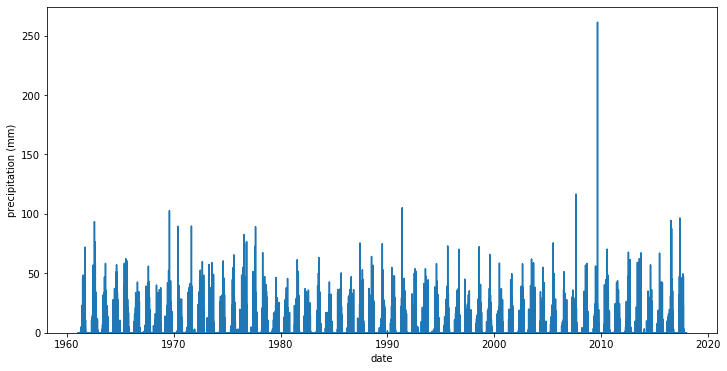

In [124]:
#plot indicative data
fig = plt.figure(figsize=(12,6))
#plt.plot(df.index,df.rainfall)
plt.plot(r_all.index,r_all.rainfall)
plt.xlabel('date')
plt.ylabel('precipitation (mm)')
plt.ylim(bottom=0)

#### ETP data
Reference evapotranspiration (𝐸𝑇0) data (Penman-Monteith) is available until 2010 only; 𝐸𝑇0 estimates for the period 2010-2016 were calculated from the daily maximum and minimum temperature using the ETo Python package (Kittridge, 2018). This uses the Hargreaves equation to calculate 𝐸𝑇0 which is recommended when insufficient data is available to calculate Penman-Monteith values (Allen et al., 1998) and has been shown to produce similar values when the quality of the input data is high (Kingston et al., 2009). Since daily maximum and minimum temperatures are not available for the period 1978-2004, it has not been possible to use a single method to estimate 𝐸𝑇0 for the entire time series; consequently the mean daily value of 𝐸𝑇0 for 2011-2016 is approximately 7% lower than the mean value for 1978-2010.

#### Testing oddments
Bits and pieces of code for testing the climate data.

In [46]:
#find stray NaNs in output (11 - 20/07/1977)
nans = r6104[~(r6104.rainfall.notna())]
nans

#check no missing days in index
check = pd.date_range(start='1961-01-01',end='2017-12-01').difference(r_all.index)
check

date  rainfall
8481 1977-07-11       NaN
8482 1977-07-12       NaN
8483 1977-07-13       NaN
8484 1977-07-14       NaN
8485 1977-07-15       NaN
8486 1977-07-16       NaN
8487 1977-07-17       NaN
8488 1977-07-18       NaN
8489 1977-07-19       NaN
8490 1977-07-20       NaN